<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/main/Thermodynamics_of_Gases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thermodynamics of Gases
This notebook uses [Cantera](https://cantera.org/) and the GRI 30 mechanism to calculate the specific heats of several gases to illustrate their variation with temperature.

In [4]:
# Quietly install Cantera -- a non-standard Colab package
%pip install -q cantera

In [5]:
# Import the required python packages
import numpy as np
import cantera as ct
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina' # Mac retina display resolution for plots

import pandas as pd

## Specific Heats
Calculate and plot the specific heats of various gases as functions of temperature.

In [6]:
# Create a Cantera solution object using the GRI 3.0 mechanism
gas = ct.Solution('gri30.yaml')
gas.basis = "molar"

# Species
species = ['H2', 'Ar', 'O2', 'CO2', 'H2O', 'CH4']

# Temperatures @ which the specific heat is to be calculated
temperatures_K = np.linspace(300, 2000, 500)


In [7]:
# Calculate the enthalpy and internal energy for each gas at each temperature
enthalpy = pd.DataFrame(index=temperatures_K, columns=species)
cp = pd.DataFrame(index=temperatures_K, columns=species)

internal_energy = pd.DataFrame(index=temperatures_K, columns=species)
cv = pd.DataFrame(index=temperatures_K, columns=species)

gamma = pd.DataFrame(index=temperatures_K, columns=species)

for s in species:
  for t in temperatures_K:
      gas.TPX = t, ct.one_atm, {s: 1}
      enthalpy.loc[t, s] = gas.h
      cp.loc[t, s] = gas.cp
      internal_energy.loc[t, s] = gas.u
      cv.loc[t, s] = gas.cv

      gamma.loc[t, s] = cp.loc[t, s]/cv.loc[t, s]


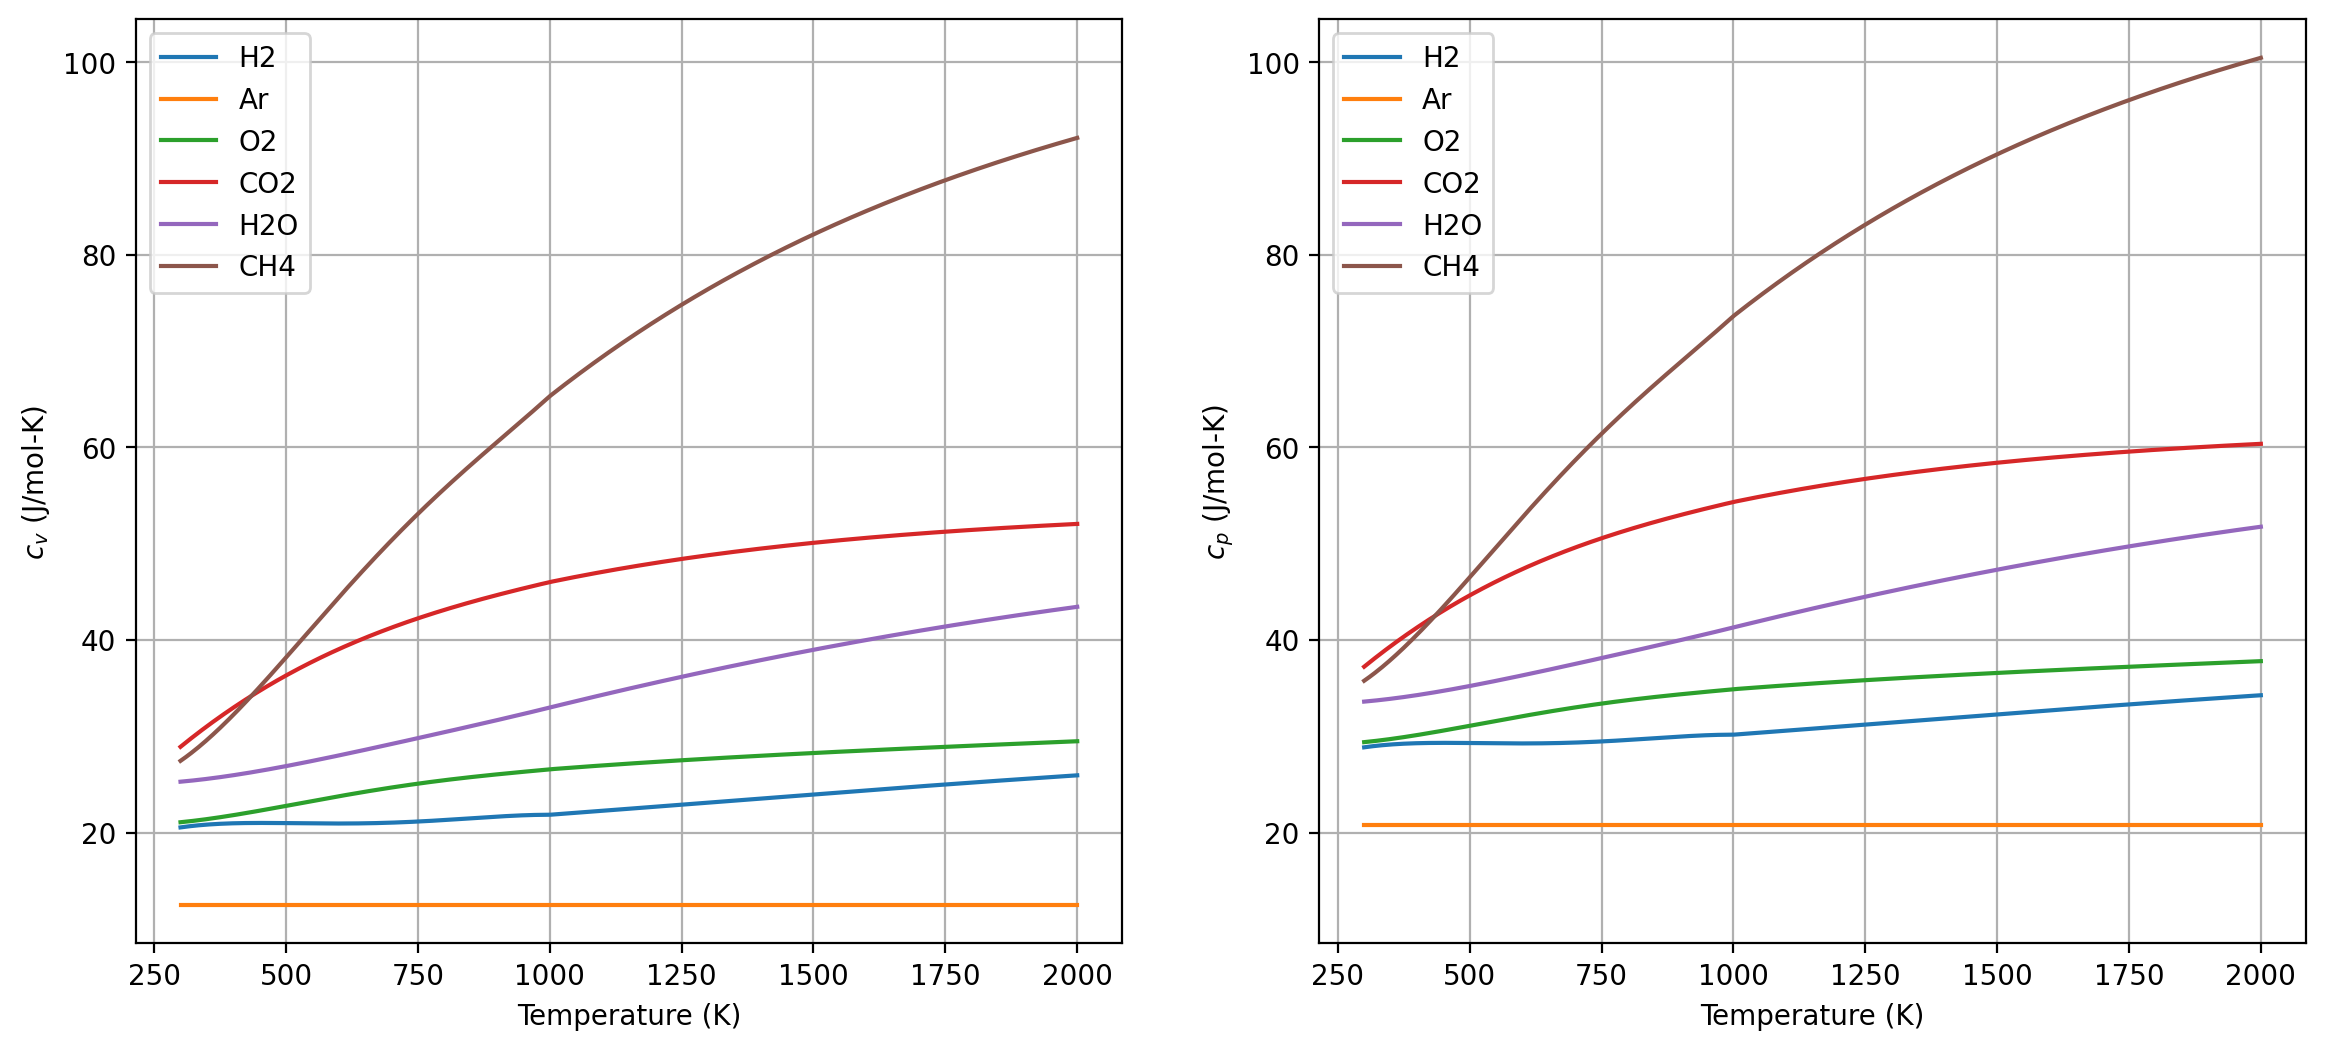

In [8]:
# Plot the specific heats vs temperature
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for s in species:
    ax[0].plot(cv.index, cv[s]/1000, label=s)
    ax[1].plot(cp.index, cp[s]/1000, label=s)

# Set the same y-axis scale for both charts - using the appropriate minimum and maximum
max_lim = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
min_lim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0])
ax[0].set_ylim(min_lim, max_lim)
ax[1].set_ylim(min_lim, max_lim)
ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel('$c_v$ (J/mol-K)')
ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('$c_p$ (J/mol-K)')
ax[0].legend(); ax[0].grid()
ax[1].legend(); ax[1].grid()
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-528967462.py:6: SyntaxWarning: invalid escape sequence '\g'
  ax.set_ylabel('$\gamma$')


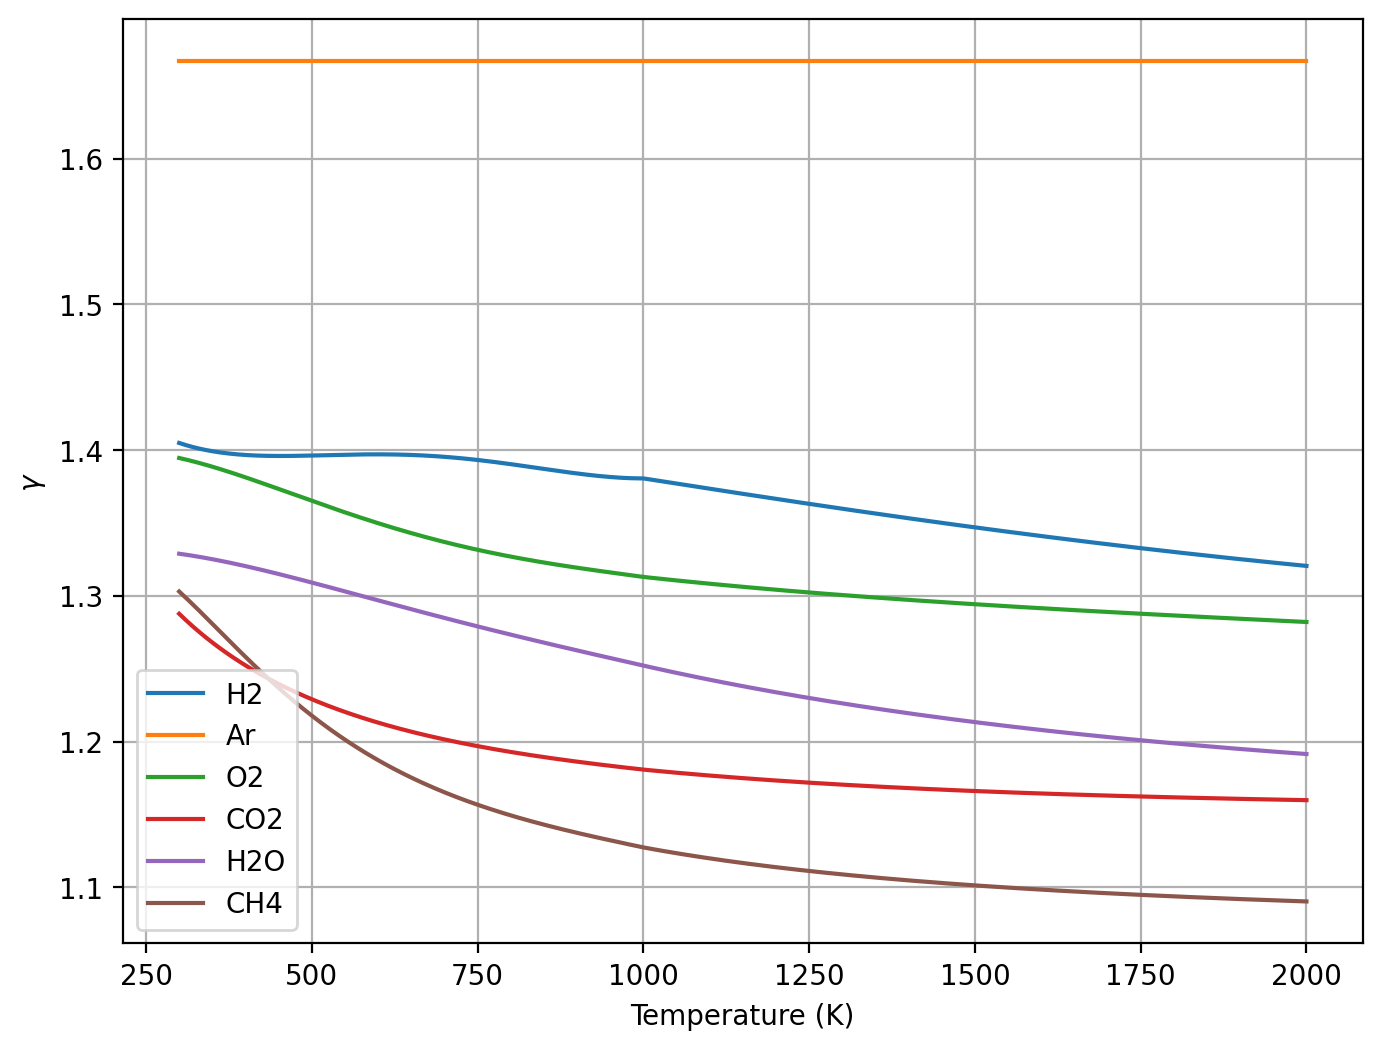

In [9]:
# Plot the ratio of specific heats for the different gases versus temperature
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for s in species:
    ax.plot(cp.index, gamma[s], label=s)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('$\gamma$')
ax.legend(); ax.grid()
plt.show()

## Compressible Flow Relations

The relationship between the total and static temperature in the adiabatic compressible flow of a calorically perfect gas may be expressed as a function of the Mach number ($M$) and the ratio of specific heats ($\gamma$).

$$\frac{T_t}{T} = 1 + \frac{\gamma-1}{2}M^2$$

For adiabatic and reversible (i.e., isentropic flows), similar relationships between the total and static pressures and densities.

$$\frac{P_t}{p} = \left(1 + \frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{\gamma-1}$$

$$\frac{\rho_t}{\rho} = \left(1 + \frac{\gamma-1}{2}M^2\right)^\frac{1}{\gamma-1}$$

In [10]:
# Handy compressible flow relations
γ1 = lambda γ: γ / (γ-1)

# Ratio of total to static temperature
Tt_T = lambda Mach, γ=1.4: 1 + (γ-1)/2*Mach**2

# Ratio of total to static pressure
Pt_p = lambda Mach, γ=1.4: Tt_T(Mach, γ)**(γ1(γ))

# Ratio of total to static density
ρt_ρ = lambda Mach, γ=1.4: Tt_T(Mach, γ)**(1/γ1(γ))


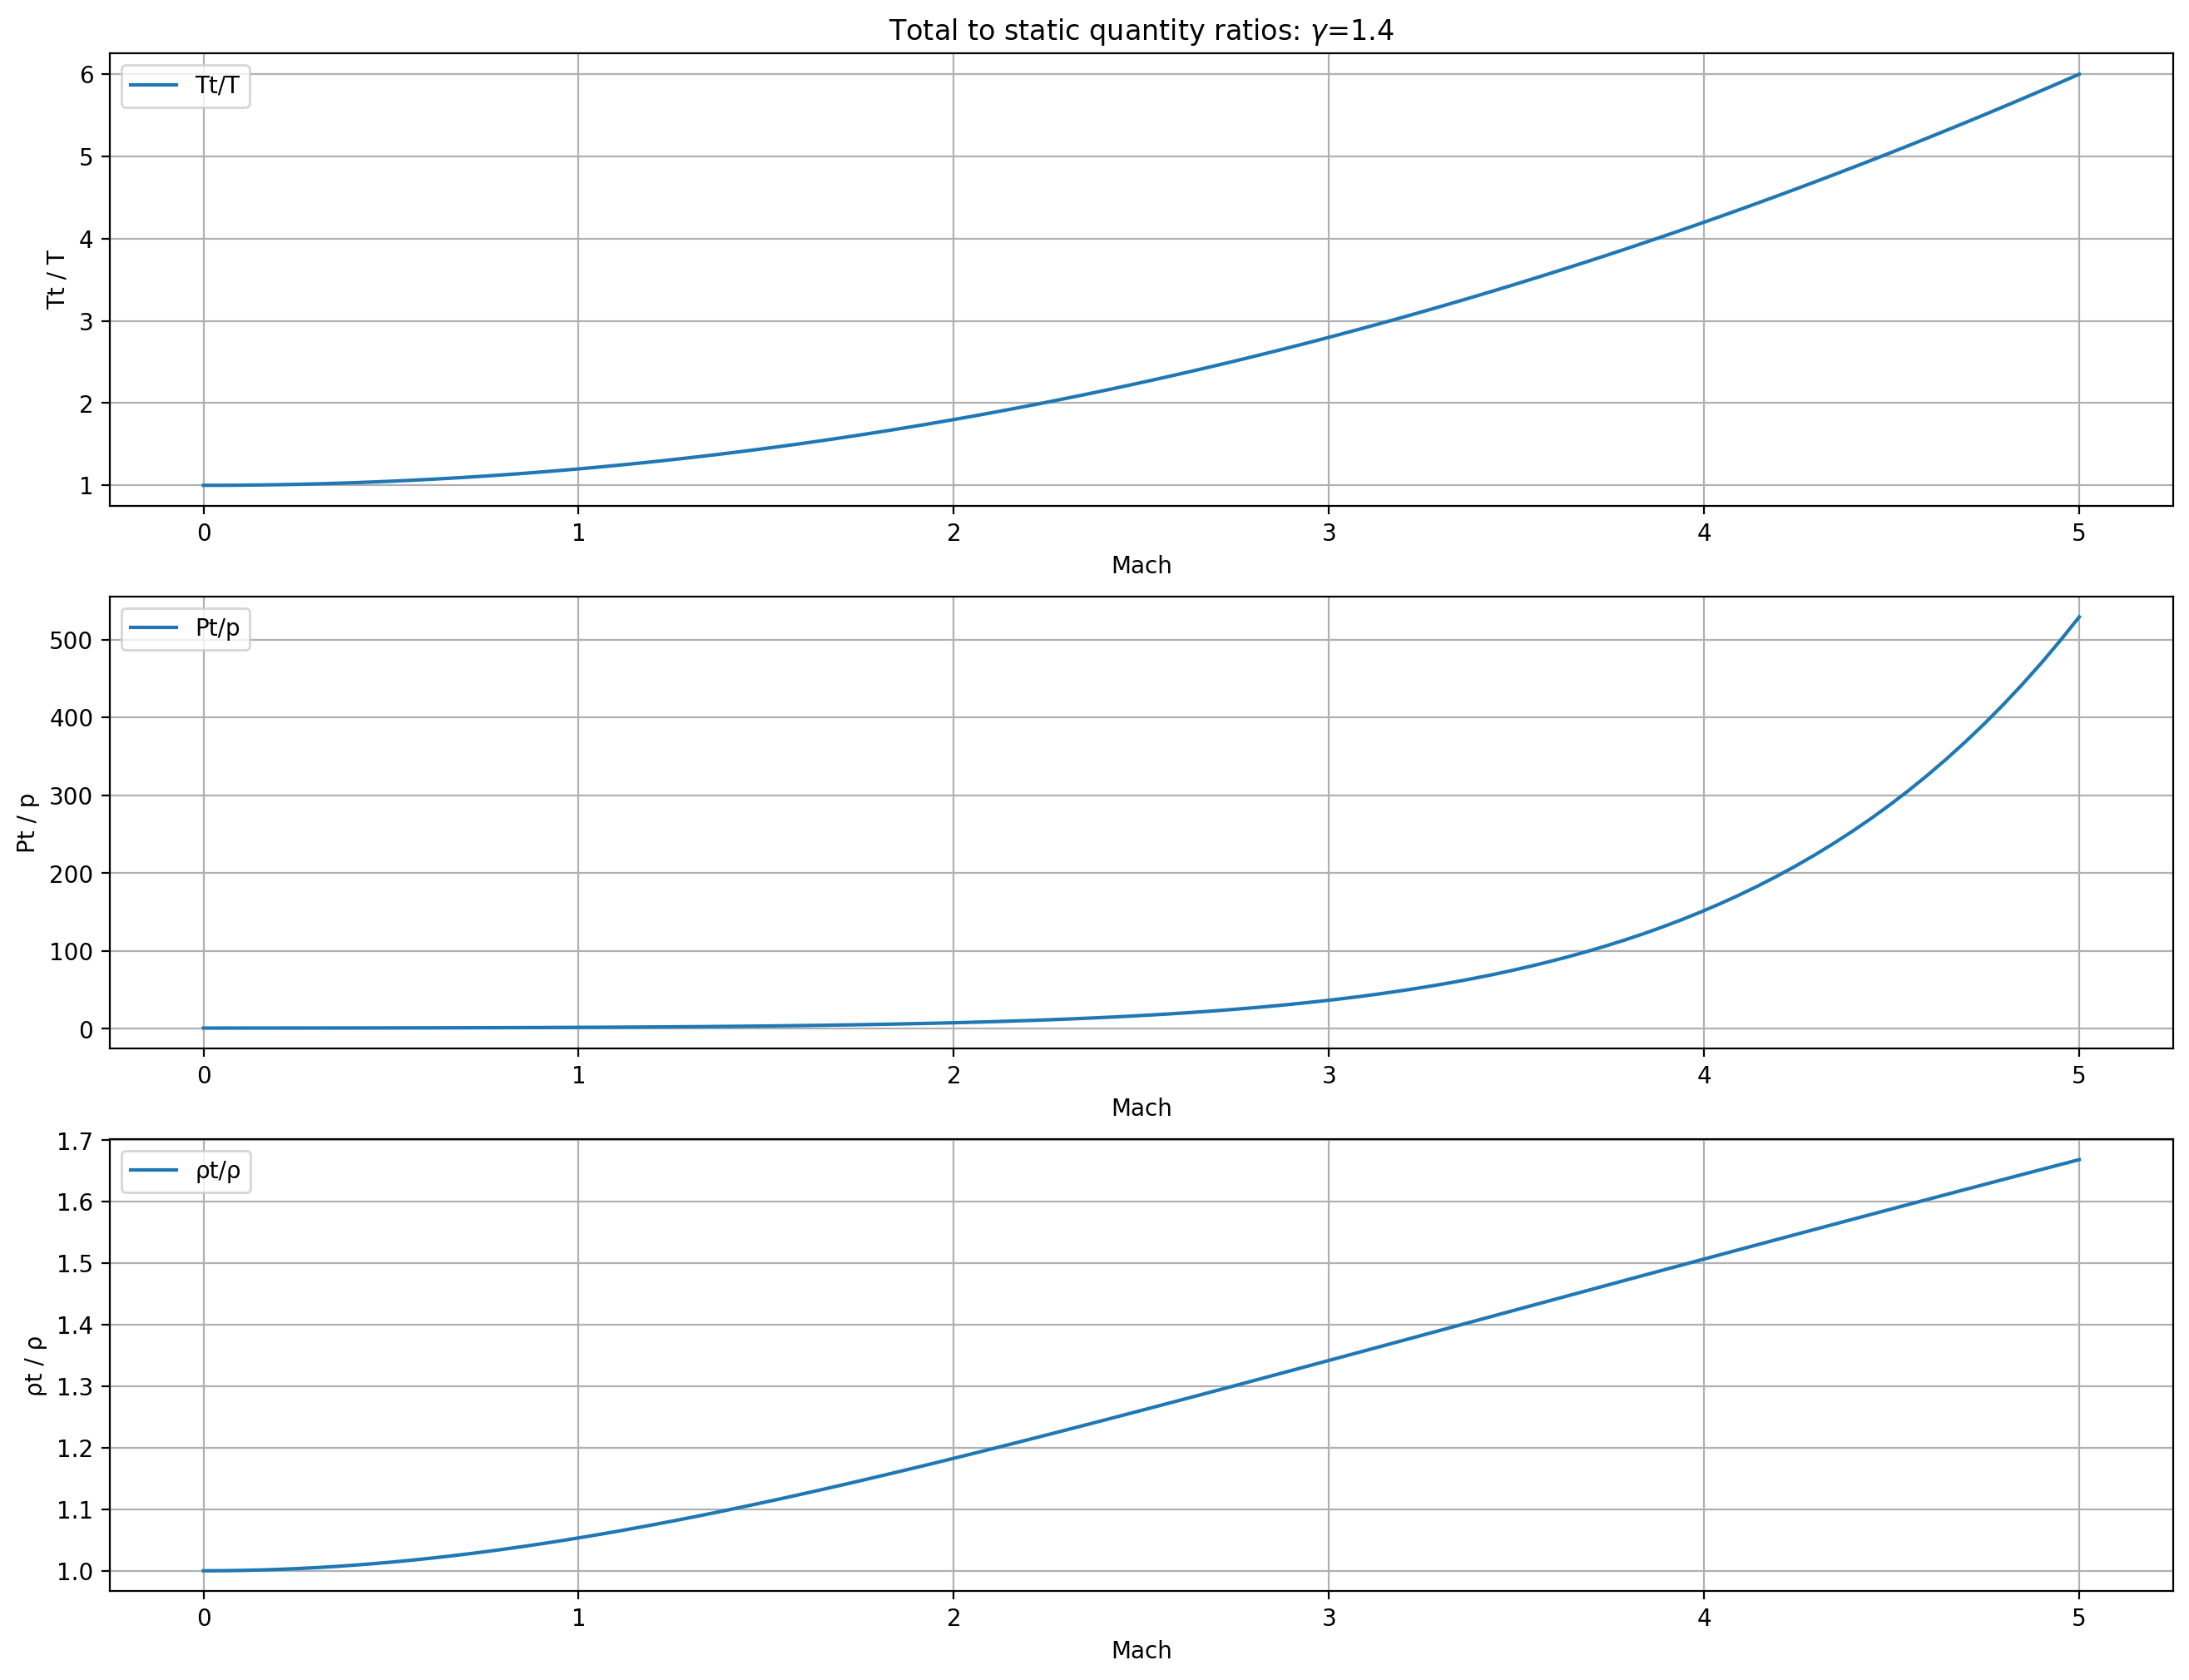

In [11]:
# Plot the total to static temperature, pressure, and density ratios versus Mach number for a fixed ratio of specific heats
Mach = np.linspace(0, 5, 100); gamma = 1.4
fig, ax = plt.subplots(3, 1, figsize=(16,12))
ax[0].plot(Mach, Tt_T(Mach, gamma), label='Tt/T')
ax[0].set_ylabel('Tt / T')
ax[1].plot(Mach, Pt_p(Mach, gamma), label='Pt/p')
ax[1].set_ylabel('Pt / p')
ax[2].plot(Mach, ρt_ρ(Mach, gamma), label='ρt/ρ')
ax[2].set_ylabel('ρt / ρ')
ax[0].set_title(f'Total to static quantity ratios: $\\gamma$={gamma}' )
for a in ax:
  a.set_xlabel('Mach')
  a.legend(); a.grid()
plt.show()

## Mass Flow / Unit Area
The mass flow unit area normalized by the product of the total density and the total speed of sound is given by
$$\frac{\rho u}{\rho_t a_t} = M\left(1+\frac{\gamma-1}{2}M^2 \right)^{\frac{1+\gamma}{2(1-\gamma)}}$$

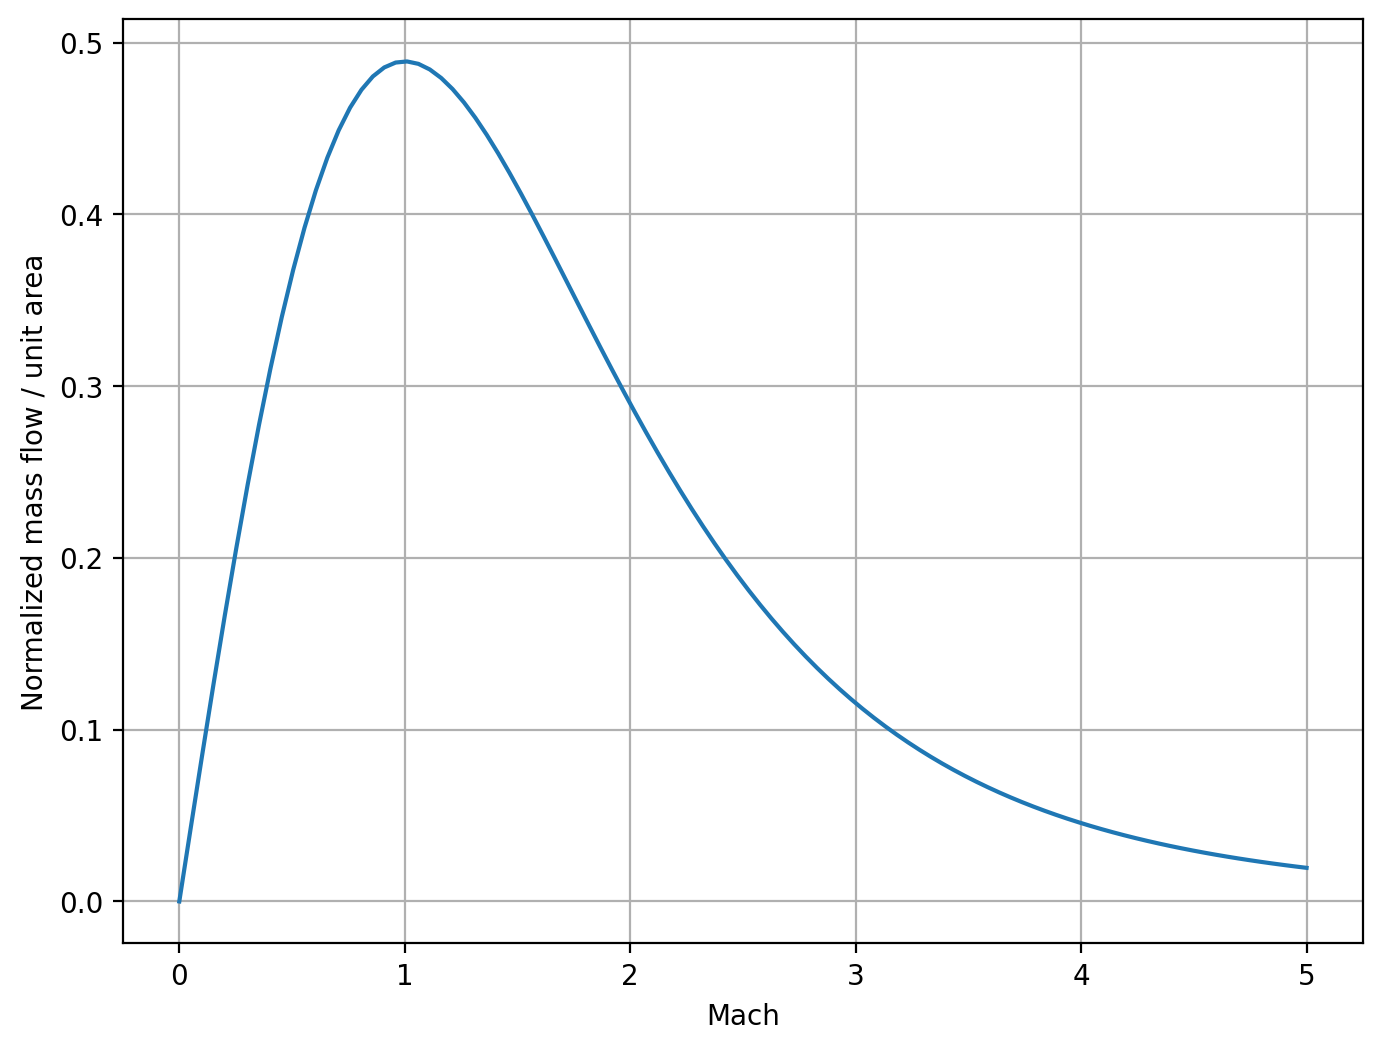

In [12]:
# Plot the normalized mass flow / unit area versus Mach
Mach = np.linspace(0, 5, 100)
mass_flux = lambda Mach, gamma: Mach/np.sqrt(gamma)*(1+((gamma-1)/2)*Mach**2)**((1+gamma)/(2*(1-gamma)))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(Mach, mass_flux(Mach, 1.4))
ax.set_xlabel('Mach')
ax.set_ylabel('Normalized mass flow / unit area')
ax.grid()
plt.show()

## Normal Shock Relations


In [20]:
class normal_shock:
  """Class to facilitate the modeling of normal shocks in calorically perfect gases"""

  def __init__(self, Mach_inflow, gamma=1.4):
    self.Mach_inflow = Mach_inflow
    self.ga = gamma

  @property
  def Mach_outflow(self):
    return  np.sqrt((self.Mach_inflow**2 + 2/(self.ga-1))/(2*self.ga/(self.ga-1)*self.Mach_inflow**2-1))

  @property
  def static_pressure_ratio(self):
    return self.Mach_inflow / self.Mach_outflow *np.sqrt(Tt_T(self.Mach_inflow, self.ga)/Tt_T(self.Mach_outflow, self.ga))

  @property
  def static_temperature_ratio(self):
    return Tt_T(self.Mach_inflow, self.ga)/Tt_T(self.Mach_outflow, self.ga)

  @property
  def total_pressure_ratio(self):
    return Pt_p(self.Mach_outflow, self.ga)/Pt_p(self.Mach_inflow, self.ga)



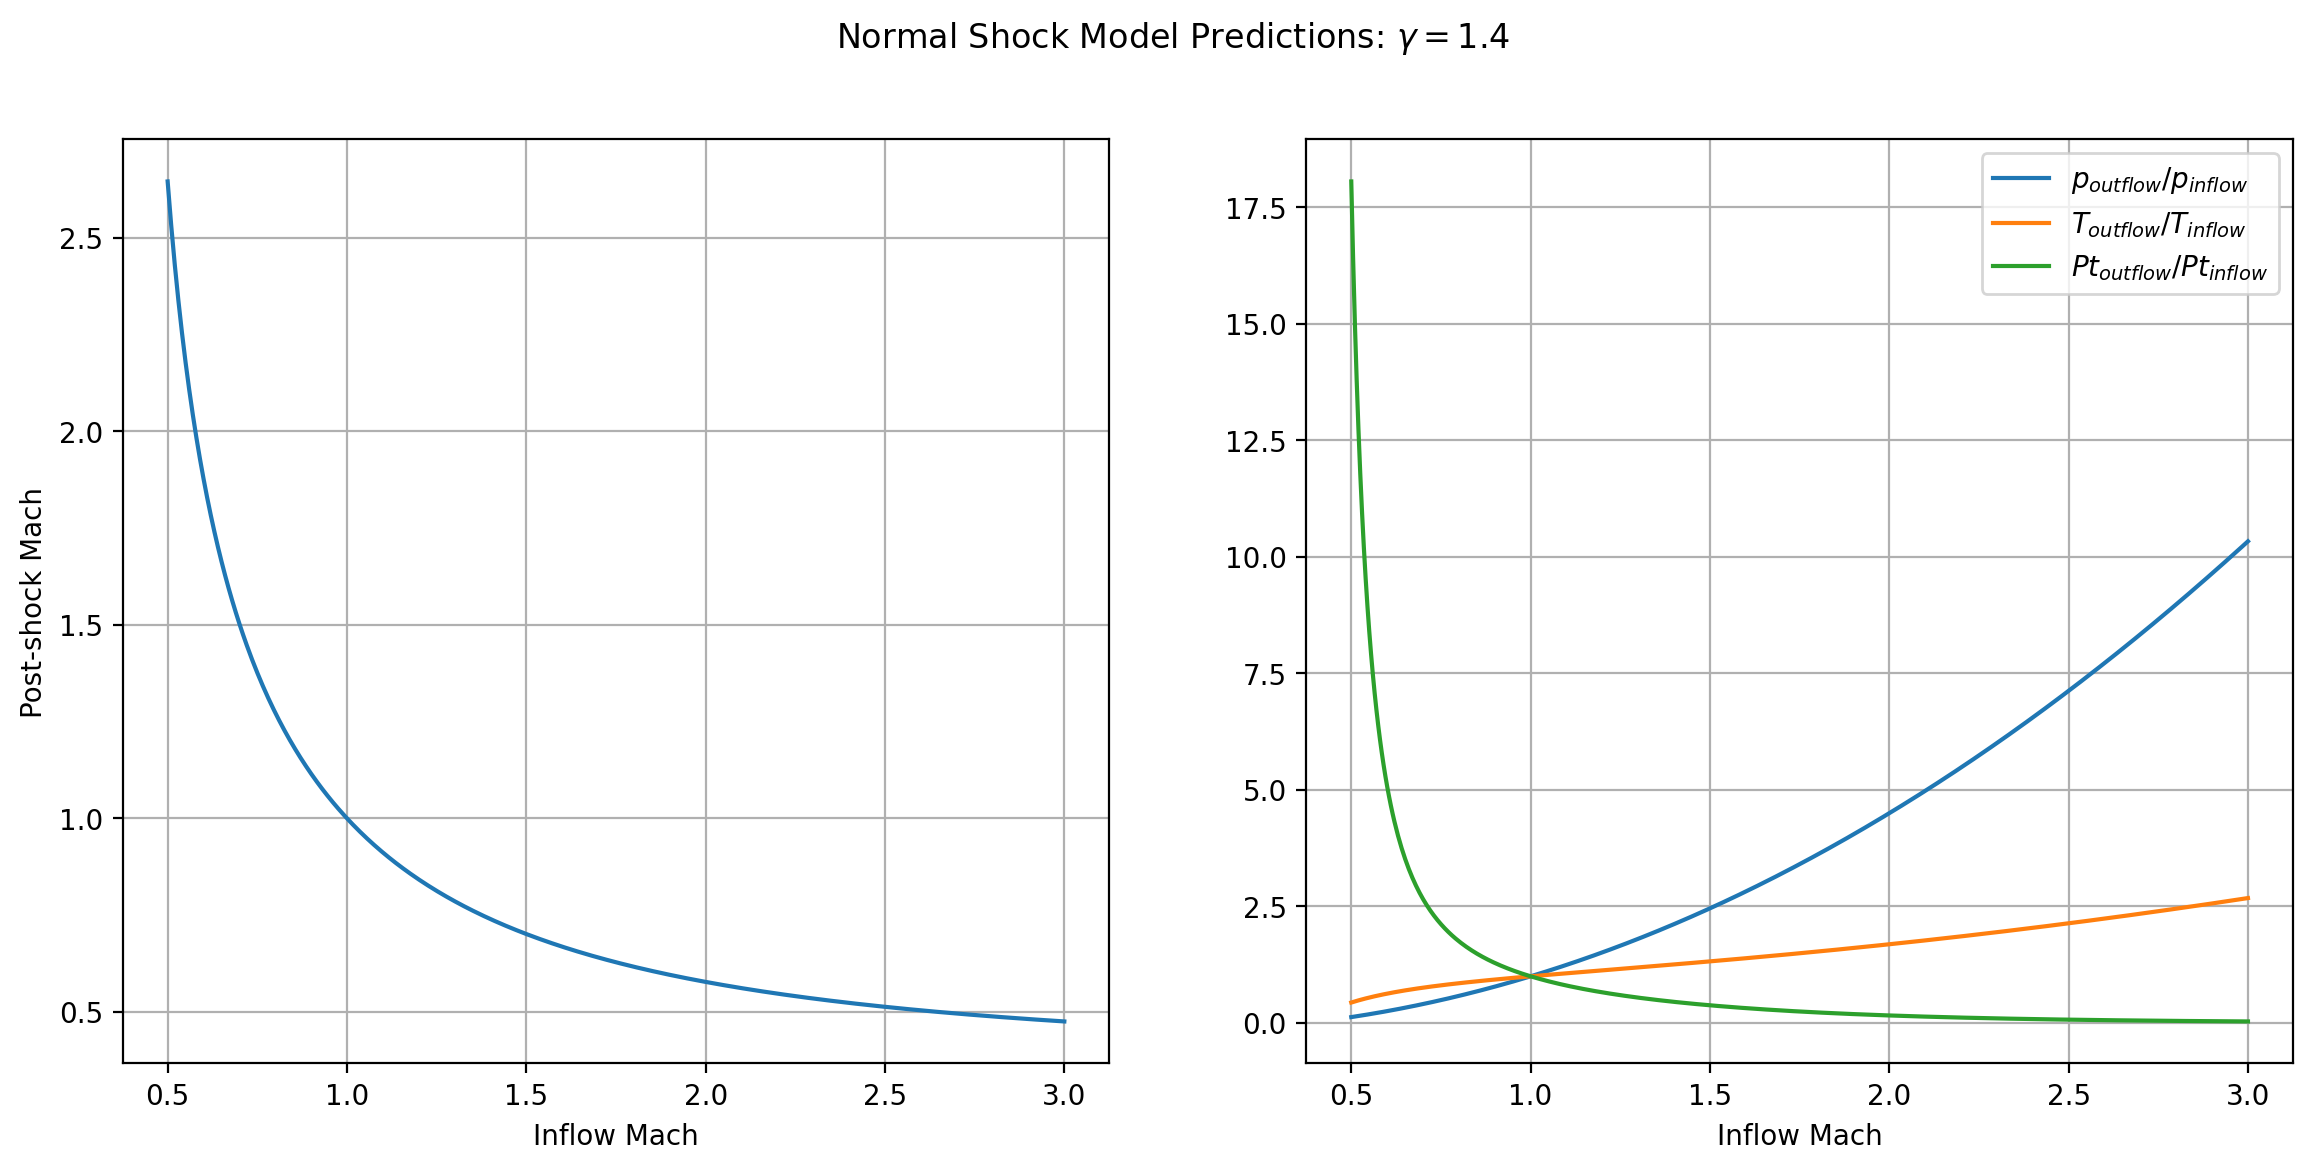

In [33]:
# Plot the post shock Mach number and static quantity ratios versus inflow Mach number
Mach_inflow = np.linspace(0.5, 3, 500)

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(Mach_inflow, normal_shock(Mach_inflow).Mach_outflow)
ax[0].set_xlabel('Inflow Mach')
ax[0].set_ylabel('Post-shock Mach')
ax[0].grid()
ax[1].plot(Mach_inflow, normal_shock(Mach_inflow).static_pressure_ratio, label='$p_{outflow} / p_{inflow}$')
ax[1].plot(Mach_inflow, normal_shock(Mach_inflow).static_temperature_ratio, label='$T_{outflow} / T_{inflow}$')
ax[1].plot(Mach_inflow, normal_shock(Mach_inflow).total_pressure_ratio, label='$Pt_{outflow} / Pt_{inflow}$')
ax[1].set_xlabel('Inflow Mach')
ax[1].grid(); ax[1].legend()
plt.suptitle(f'Normal Shock Model Predictions: $\\gamma=${1.4}')
plt.show()